**1. Cargar Librerías y Configuración Inicial**

Este bloque importa las librerías necesarias y configura las rutas a los datos.

In [23]:
!pip install torchsummary
!pip install torchinfo
!pip install optuna
!pip install plotly

In [24]:
import pandas as pd
import ast
import os
import zipfile
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchinfo import summary
import torch.optim as optim
import torch.nn as nn
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation, ColorJitter
import optuna
import optuna.visualization as vis
import plotly
import random

# Ruta de los datos
csv_path = '/content/sample_data/poi_dataset.csv'
zip_path = '/content/sample_data/data_main.zip'  # Ruta al ZIP de imágenes
image_root_dir = '/content/sample_data/data_main'  # Directorio donde estarán las imágenes

# Limpiar directorio si existe
if os.path.exists(image_root_dir):
    print(f"Eliminando carpeta existente: {image_root_dir}")
    shutil.rmtree(image_root_dir)

# Extraer contenido del ZIP sin anidación redundante
print("Extrayendo data_main.zip...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for member in zip_ref.namelist():
        # Ignorar la carpeta principal (si existe)
        path_components = member.split('/')
        if len(path_components) > 1 and path_components[0] == 'data_main':
            target_path = os.path.join(image_root_dir, '/'.join(path_components[1:]))

            # Si es una carpeta, crea la carpeta
            if member.endswith('/'):
                os.makedirs(target_path, exist_ok=True)
            else:
                # Si es un archivo, escribe el archivo
                os.makedirs(os.path.dirname(target_path), exist_ok=True)
                with open(target_path, 'wb') as f:
                    f.write(zip_ref.read(member))

print(f"Imágenes extraídas en: {image_root_dir}")

Eliminando carpeta existente: /content/sample_data/data_main
Extrayendo data_main.zip...
Imágenes extraídas en: /content/sample_data/data_main


**Configuración del dispositivo**

In [25]:
# Configuración de la semilla para reproducibilidad
seed = 42
np.random.seed(seed)  # Configura la semilla para NumPy
torch.manual_seed(seed)  # Configura la semilla para PyTorch

print(f"Semilla configurada en {seed} para reproducibilidad.")

Semilla configurada en 42 para reproducibilidad.


In [26]:
# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


**2. Cargar y Limpiar Datos**

Carga el dataset desde un archivo CSV y elimina duplicados para garantizar datos únicos.

In [27]:
# Cargar el archivo CSV
poi_data = pd.read_csv(csv_path)

# Eliminar duplicados basándose en el ID único
poi_data_cleaned = poi_data.drop_duplicates(subset=['id'])

# Mostrar las primeras filas para inspección
print("Datos cargados. Primeras filas:")
print(poi_data_cleaned.head())


Datos cargados. Primeras filas:
                                     id  \
0  4b36a3ed-3b28-4bc7-b975-1d48b586db03   
1  e32b3603-a94f-49df-8b31-92445a86377c   
2  0123a69b-13ac-4b65-a5d5-71a95560cff5   
3  390d7d9e-e972-451c-b5e4-f494af15e788   
4  023fc1bf-a1cd-4b9f-af78-48792ab1a294   

                                                name  \
0                                  Galería Fran Reus   
1                            Convento de San Plácido   
2             Instituto Geológico y Minero de España   
3                              Margarita Gil Roësset   
4  Museo del Traje. Centro de Investigación del P...   

                                    shortDescription  \
0  La Galería Fran Reus es un espacio dedicado a ...   
1  El Convento de San Plácido en Madrid, fundado ...   
2  El Instituto Geológico y Minero de España, sit...   
3  Margarita Gil Roësset, escultora y poetisa esp...   
4  El Museo del Traje de Madrid, fundado en 2004,...   

                   categories  tier

**3. Crear Métricas de Engagement**

Crea una métrica combinada de engagement, la normaliza, y genera una variable binaria (alto/bajo engagement).

In [28]:
poi_data_cleaned = poi_data_cleaned.copy()

# Crear una métrica de engagement combinada
poi_data_cleaned.loc[:, 'engagement_score'] = (
    poi_data_cleaned['Visits'] +
    poi_data_cleaned['Likes'] * 2 +
    poi_data_cleaned['Bookmarks'] * 1.5 -
    poi_data_cleaned['Dislikes']
)

# Normalizar la métrica de engagement
engagement_min = poi_data_cleaned['engagement_score'].min()
engagement_max = poi_data_cleaned['engagement_score'].max()

poi_data_cleaned.loc[:, 'engagement_normalized'] = (
    (poi_data_cleaned['engagement_score'] - engagement_min) /
    (engagement_max - engagement_min)
)

# Crear una variable binaria para engagement
engagement_median = poi_data_cleaned['engagement_normalized'].median()

poi_data_cleaned.loc[:, 'engagement_binary'] = (
    poi_data_cleaned['engagement_normalized'] > engagement_median
).astype(int)

# Mostrar estadísticas de la métrica
print("Métrica de engagement creada y normalizada.")
print(poi_data_cleaned[['engagement_score', 'engagement_normalized', 'engagement_binary']].describe())

Métrica de engagement creada y normalizada.
       engagement_score  engagement_normalized  engagement_binary
count       1492.000000            1492.000000        1492.000000
mean       16094.553284               0.226687           0.500000
std        13097.299050               0.183571           0.500168
min          -79.000000               0.000000           0.000000
25%         7404.250000               0.104885           0.000000
50%         9131.000000               0.129087           0.500000
75%        22398.500000               0.315043           1.000000
max        71268.500000               1.000000           1.000000


**Codificar Categorías**

Convierte las categorías en listas y las codifica utilizando One-Hot Encoding.

In [29]:
# Convertir las categorías en listas reales usando
poi_data_cleaned.loc[:, 'categories_list'] = poi_data_cleaned['categories'].apply(lambda x: ast.literal_eval(x))

# Realizar One-Hot Encoding para las categorías
categories_encoded = pd.get_dummies(
    poi_data_cleaned['categories_list'].apply(pd.Series).stack()
).groupby(level=0).sum()

# Combinar el resultado con el DataFrame original
poi_data_with_categories = pd.concat([poi_data_cleaned, categories_encoded], axis=1)

# Mostrar las primeras columnas de categorías codificadas
print("Categorías codificadas. Ejemplo de columnas codificadas:")
print(categories_encoded.head())

Categorías codificadas. Ejemplo de columnas codificadas:
   Arquitectura  Ciencia  Cine  Cultura  Escultura  Gastronomía  Historia  \
0             0        0     0        0          1            0         0   
1             0        0     0        0          0            0         1   
2             0        1     0        0          0            0         0   
3             0        0     0        1          0            0         0   
4             0        0     0        1          0            0         0   

   Misterio  Naturaleza  Ocio  Patrimonio  Pintura  
0         0           0     0           0        1  
1         0           0     0           1        0  
2         0           0     0           1        0  
3         0           0     0           0        0  
4         0           0     0           1        0  


**Ajustar Rutas de Imágenes**

Genera rutas completas a las imágenes main.jpg en el directorio descomprimido.

In [30]:
# Ajustar las rutas de las imágenes
poi_data_with_categories['adjusted_image_path'] = poi_data_with_categories['id'].apply(
    lambda poi_id: os.path.join(image_root_dir, poi_id, 'main.jpg')
)
# Mostrar ejemplos de rutas ajustadas
print("Rutas de imágenes ajustadas. Ejemplo:")
print(poi_data_with_categories[['id', 'adjusted_image_path']].head())

Rutas de imágenes ajustadas. Ejemplo:
                                     id  \
0  4b36a3ed-3b28-4bc7-b975-1d48b586db03   
1  e32b3603-a94f-49df-8b31-92445a86377c   
2  0123a69b-13ac-4b65-a5d5-71a95560cff5   
3  390d7d9e-e972-451c-b5e4-f494af15e788   
4  023fc1bf-a1cd-4b9f-af78-48792ab1a294   

                                 adjusted_image_path  
0  /content/sample_data/data_main/4b36a3ed-3b28-4...  
1  /content/sample_data/data_main/e32b3603-a94f-4...  
2  /content/sample_data/data_main/0123a69b-13ac-4...  
3  /content/sample_data/data_main/390d7d9e-e972-4...  
4  /content/sample_data/data_main/023fc1bf-a1cd-4...  


**Preprocesar Imágenes**

Redimensiona y normaliza las imágenes para que sean compatibles con el modelo de Deep Learning.

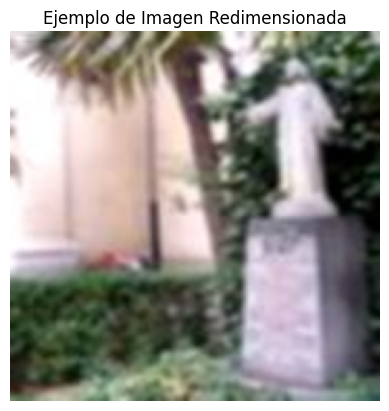

In [31]:
# Tamaño deseado para las imágenes
IMAGE_SIZE = (224, 224)

# Función para redimensionar y normalizar una imagen
def preprocess_image(image_path, target_size=IMAGE_SIZE):
    try:
        with Image.open(image_path) as img:
            img = img.resize(target_size)  # Redimensionar
            img_array = np.array(img) / 255.0  # Normalizar
            return img_array
    except Exception as e:
        print(f"Error procesando la imagen {image_path}: {e}")
        return None

# Procesar todas las imágenes disponibles
poi_data_with_categories['processed_image'] = poi_data_with_categories['adjusted_image_path'].apply(
    lambda path: preprocess_image(path) if os.path.exists(path) else None
)

# Extraer una imagen procesada para mostrar
random_index = random.randint(0, len(poi_data_with_categories) - 1)
example_image = poi_data_with_categories['processed_image'].iloc[random_index]

# Mostrar la imagen redimensionada
if example_image is not None:
    plt.imshow(example_image)  # Mostrar la imagen
    plt.axis('off')  # Ocultar los ejes
    plt.title("Ejemplo de Imagen Redimensionada")
    plt.show()
else:
    print("No se encontró ninguna imagen procesada para mostrar.")


**Resumen del Preprocesamiento**

Genera un resumen del número de imágenes procesadas correctamente y las que fallaron.

In [32]:
# Verificar cuántas imágenes se procesaron correctamente
total_images = len(poi_data_with_categories)
processed_count = poi_data_with_categories['processed_image'].notnull().sum()
failed_count = total_images - processed_count

# Mostrar resumen del preprocesamiento
preprocessing_summary = {
    "Total imágenes": total_images,
    "Imágenes procesadas": processed_count,
    "Errores en procesamiento": failed_count,
}

print("Resumen del preprocesamiento:")
print(preprocessing_summary)

Resumen del preprocesamiento:
{'Total imágenes': 1492, 'Imágenes procesadas': 1492, 'Errores en procesamiento': 0}


**Transformaciones para las Imágenes**

Define las transformaciones para imágenes, asegurando compatibilidad con el modelo preentrenado (ResNet-18).

In [33]:
# Transformaciones para imágenes
#transform = transforms.Compose([
   # transforms.Resize((224, 224)),  # Redimensionar
  #  transforms.ToTensor(),         # Convertir a tensores
 #   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar como en modelos preentrenados
#])

#print("Transformaciones definidas correctamente.")

# Transformaciones con Data Augmentation para entrenamiento
transform = Compose([
    RandomHorizontalFlip(p=0.5),  # Volteo horizontal con probabilidad del 50%
    RandomRotation(degrees=15),  # Rotación aleatoria de ±15 grados
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Cambios de brillo, contraste y saturación
    Resize((224, 224)),  # Redimensionar
    ToTensor(),  # Convertir a tensores
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar como en modelos preentrenados
])

# Transformaciones para validación y prueba
val_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transformaciones con Data Augmentation definidas correctamente para entrenamiento.")


Transformaciones con Data Augmentation definidas correctamente para entrenamiento.


**División en Train/Validation/Test**

Divide los datos en 3 conjuntos:

Entrenamiento (train): 64%, Validación (validation): 16% y Prueba (test): 20%

In [34]:
# Dividir los datos en conjuntos (80% train y val, 20% test)
train_df, test_df = train_test_split(poi_data_with_categories, test_size=0.2, random_state=42)

# Dividir el conjunto de entrenamiento en train y validation (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"División completada: Train={len(train_df)}, Validation={len(val_df)}, Test={len(test_df)}")



División completada: Train=954, Validation=239, Test=299


**Definir las columnas de metadatos y verificar datos**

In [35]:
# Definir columnas de metadatos
metadata_columns = ['Visits', 'Likes', 'Dislikes', 'Bookmarks']  # Ajustar si hay más columnas

# Verifica la cantidad de columnas reales
print(f"Columnas de metadatos utilizadas: {metadata_columns}")
print(train_df[metadata_columns].head())


Columnas de metadatos utilizadas: ['Visits', 'Likes', 'Dislikes', 'Bookmarks']
      Visits  Likes  Dislikes  Bookmarks
893    10005   3482      1153        562
1079   10014   2952      1524        610
1213   10017  23817       221       7014
349    10012   8413        99       2684
858    10013    670      7908        281


**Definir la Arquitectura del Modelo Híbrido**

Definimos el modelo híbrido, extraemos características visuales usando ResNet-18, Procesa los datos estructurados y combinamos ambas salidas para realizar la clasificación.

In [36]:
class HybridModel(nn.Module):
    def __init__(self, num_metadata_features, num_classes=2, dropout_prob=0.3):
        super(HybridModel, self).__init__()

        # 1. Rama de imágenes (ResNet preentrenado)
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        num_features_cnn = self.cnn.fc.in_features
        self.cnn.fc = nn.Identity()  # Eliminar la capa FC final

        # 2. Rama de metadatos (fully-connected)
        self.metadata_fc = nn.Sequential(
            nn.Linear(num_metadata_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),  # Usar el dropout_prob
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # 3. Capa fusionada y clasificación
        self.classifier = nn.Sequential(
            nn.Linear(num_features_cnn + 64, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),  # Usar el dropout_prob
            nn.Linear(128, num_classes)
        )

    def forward(self, image, metadata):
        # Rama de imágenes
        image_features = self.cnn(image)  # Salida: [batch_size, num_features]

        # Rama de metadatos
        metadata_features = self.metadata_fc(metadata)  # Salida: [batch_size, 64]

        # Concatenar ambas ramas
        combined = torch.cat((image_features, metadata_features), dim=1)

        # Clasificación
        output = self.classifier(combined)
        return output


**Instanciar y Visualizar el Modelo Híbrido**

Este bloque calcula dinámicamente el número de características de los metadatos y ajusta el modelo híbrido para que coincida. Además, se imprime un resumen del modelo para verificar que las dimensiones son correctas.

In [37]:
# Calcular el número de características de metadatos
num_metadata_features = len(metadata_columns)

# Crear el modelo ajustado
model = HybridModel(num_metadata_features=num_metadata_features, num_classes=2)

# Mostrar resumen del modelo
summary(
    model,
    input_data=(torch.randn(1, 3, 224, 224), torch.randn(1, num_metadata_features)),
    col_names=["input_size", "output_size", "num_params"],
    device="cpu"
)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
HybridModel                                   [1, 3, 224, 224]          [1, 2]                    --
├─ResNet: 1-1                                 [1, 3, 224, 224]          [1, 512]                  --
│    └─Conv2d: 2-1                            [1, 3, 224, 224]          [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 112, 112]         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 64, 56, 56]           [1, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 56, 56]           [1, 64, 56, 56]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 56, 56]           [1, 64

**Crear un Dataset Personalizado**

Define la clase POIDataset, que carga imágenes desde las rutas proporcionadas, carga metadatos desde columnas específicas y devuelve imágenes, metadatos y etiquetas para cada muestra.

In [38]:
class POIDataset(Dataset):
    def __init__(self, dataframe, metadata_columns, transform=None):
        self.dataframe = dataframe
        self.metadata_columns = metadata_columns
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Validar índice
        if idx >= len(self.dataframe):
            raise IndexError("Índice fuera de rango.")

        row = self.dataframe.iloc[idx]

        # Procesar imagen
        image_path = row['adjusted_image_path']
        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error al procesar la imagen en {image_path}: {e}")
            image = torch.zeros(3, 224, 224)  # Imagen vacía como fallback

        # Procesar metadatos
        metadata = torch.tensor(row[self.metadata_columns].to_numpy(dtype=np.float32))

        # Etiqueta
        label = torch.tensor(row['engagement_binary'], dtype=torch.long)
        return image, metadata, label





**Crear los datasets personalizados**

Este bloque utiliza la clase POIDataset para crear datasets personalizados para los subconjuntos de entrenamiento, validación y prueba.

In [39]:
# Crear datasets personalizados usando la clase POIDataset
#train_dataset = POIDataset(dataframe=train_df, metadata_columns=metadata_columns, transform=transform)
#val_dataset = POIDataset(dataframe=val_df, metadata_columns=metadata_columns, transform=transform)
#test_dataset = POIDataset(dataframe=test_df, metadata_columns=metadata_columns, transform=transform)

#print("Datasets creados correctamente.")

# Crear datasets personalizados
train_dataset = POIDataset(dataframe=train_df, metadata_columns=metadata_columns, transform=transform)
val_dataset = POIDataset(dataframe=val_df, metadata_columns=metadata_columns, transform=val_transform)
test_dataset = POIDataset(dataframe=test_df, metadata_columns=metadata_columns, transform=val_transform)

print("Datasets creados con Data Augmentation aplicado al conjunto de entrenamiento.")

Datasets creados con Data Augmentation aplicado al conjunto de entrenamiento.


**Crear DataLoaders**

Este bloque crea los datasets y DataLoaders necesarios para manejar los datos de entrenamiento, validación y prueba.

In [40]:
# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Datasets y DataLoaders creados correctamente.")


Datasets y DataLoaders creados correctamente.


**Funciones auxiliares (train_one_epoch, validate_one_epoch, train_model)**

**Ciclo de Entrenamiento**

Implementa un ciclo de entrenamiento por una época:

Calcula la pérdida y realiza el backward pass, optimiza los pesos del modelo y calcula la pérdida promedio y la precisión.

In [41]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()  # Modo entrenamientoFunciones auxiliares (train_one_epoch, validate_one_epoch, train_model)


    running_loss = 0.0
    correct = 0
    total = 0

    for images, metadata, labels in train_loader:
        # Enviar datos al dispositivo
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

        # Forward pass
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular estadísticas
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

**Ciclo de Validación**

No se calculan gradientes (torch.no_grad()) y se calcula la pérdida promedio y la precisión.

In [42]:
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()  # Modo evaluación
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, metadata, labels in val_loader:
            # Enviar datos al dispositivo
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

            # Forward pass
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)

            # Calcular estadísticas
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    accuracy = 100. * correct / total
    return epoch_loss, accuracy


**Bloque 3: Configuración del Pipeline**

Función de pérdida: Cross-entropy para clasificación multiclase.

Optimizador: Adam, adecuado para problemas complejos como redes profundas.

Scheduler: Reduce el learning rate cada 10 épocas para estabilizar el entrenamiento.


In [43]:
# Configuración del pipeline
criterion = nn.CrossEntropyLoss()  # Función de pérdida para clasificación multiclase
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizador Adam con learning rate inicial
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reducción del learning rate

print("Pipeline configurado: Pérdida, optimizador y scheduler listos.")


Pipeline configurado: Pérdida, optimizador y scheduler listos.


In [44]:
def train_model_with_early_stopping(
    model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, device, patience=5
):
    """
    Entrena el modelo con Early Stopping.
    Args:
        model: El modelo a entrenar.
        train_loader: DataLoader del conjunto de entrenamiento.
        val_loader: DataLoader del conjunto de validación.
        optimizer: Optimizador utilizado para el entrenamiento.
        criterion: Función de pérdida utilizada.
        scheduler: Scheduler para ajustar el learning rate.
        num_epochs: Número máximo de épocas.
        device: Dispositivo (CPU o GPU) para el entrenamiento.
        patience (int): Número de épocas consecutivas sin mejora en la pérdida de validación para detener el entrenamiento.
    """
    model = model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, num_epochs + 1):
        print(f"\nÉpoca {epoch}/{num_epochs}")

        # Entrenamiento
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validación
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Mostrar resultados de la época
        print(f"Entrenamiento - Pérdida: {train_loss:.4f}, Precisión: {train_acc:.2f}%")
        print(f"Validación - Pérdida: {val_loss:.4f}, Precisión: {val_acc:.2f}%")

        # Verificar Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Guardar el mejor modelo
            torch.save(model.state_dict(), 'best_model.pth')
            print("Modelo mejorado y guardado.")
        else:
            patience_counter += 1
            print(f"Sin mejora en la validación. Paciencia: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("\nEarly Stopping activado. Entrenamiento detenido.")
            break

        # Actualizar el learning rate
        scheduler.step()

    # Cargar el mejor modelo
    model.load_state_dict(torch.load('best_model.pth'))
    return history


# **Ejecutar el entrenamiento**
num_epochs = 20
patience = 5
# Llamar a la función de entrenamiento
history = train_model_with_early_stopping(
    model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, device, patience
)



Época 1/20
Entrenamiento - Pérdida: 18.9354, Precisión: 79.14%
Validación - Pérdida: 4.9152, Precisión: 97.07%
Modelo mejorado y guardado.

Época 2/20
Entrenamiento - Pérdida: 2.7311, Precisión: 92.35%
Validación - Pérdida: 0.3968, Precisión: 93.72%
Modelo mejorado y guardado.

Época 3/20
Entrenamiento - Pérdida: 2.0610, Precisión: 93.19%
Validación - Pérdida: 0.2903, Precisión: 98.33%
Modelo mejorado y guardado.

Época 4/20
Entrenamiento - Pérdida: 1.4853, Precisión: 92.35%
Validación - Pérdida: 0.4382, Precisión: 98.33%
Sin mejora en la validación. Paciencia: 1/5

Época 5/20
Entrenamiento - Pérdida: 1.2423, Precisión: 92.45%
Validación - Pérdida: 0.3464, Precisión: 98.33%
Sin mejora en la validación. Paciencia: 2/5

Época 6/20
Entrenamiento - Pérdida: 0.7020, Precisión: 94.13%
Validación - Pérdida: 0.0588, Precisión: 98.33%
Modelo mejorado y guardado.

Época 7/20
Entrenamiento - Pérdida: 0.7040, Precisión: 92.98%
Validación - Pérdida: 0.1358, Precisión: 98.33%
Sin mejora en la valid

<ipython-input-44-976e71c0980e>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


**Optuna**

**Mostrar visualizaciones Optuna**

In [48]:
# Mostrar los mejores ensayos
def show_best_trials(study, top_n=5):
    """
    Muestra los mejores ensayos del estudio.
    """
    completed_trials = [t for t in study.trials if t.value is not None]
    best_trials = sorted(completed_trials, key=lambda t: t.value)[:top_n]

    print("\nMejores ensayos:")
    print("Número de ensayo\tValor")
    for trial in best_trials:
        print(f"#{trial.number}\t\t{trial.value:.4f}")

show_best_trials(study)


Mejores ensayos:
Número de ensayo	Valor
#0		0.8101


In [47]:
import optuna

# Función para optimizar
def objective(trial):
    """
    Función objetivo para que Optuna optimice.
    """
    # Definir los hiperparámetros que quieres optimizar
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    step_size = trial.suggest_int("step_size", 5, 20)
    gamma = trial.suggest_float("gamma", 0.1, 0.9)

    # Aquí incluirías tu modelo, entrenamiento y evaluación
    # Por ejemplo:
    model = HybridModel(num_metadata_features=len(metadata_columns), num_classes=2, dropout_prob=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # Entrenamiento con Early Stopping
    history = train_model_with_early_stopping(
        model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=15, device=device, patience=5
    )

    # Usar la pérdida de validación como métrica de evaluación
    return history['val_loss'][-1]

# Crear un estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1)

# Mostrar los mejores ensayos
def show_best_trials(study, top_n=5):
    """
    Muestra los mejores ensayos del estudio.
    """
    completed_trials = [t for t in study.trials if t.value is not None]
    best_trials = sorted(completed_trials, key=lambda t: t.value)[:top_n]

    print("\nMejores ensayos:")
    print("Número de ensayo\tValor")
    for trial in best_trials:
        print(f"#{trial.number}\t\t{trial.value:.4f}")

# Llamar a la función para mostrar los mejores ensayos
show_best_trials(study)



[I 2025-01-26 17:58:07,595] A new study created in memory with name: no-name-150b5629-e1dc-461f-8179-6d99b666402b



Época 1/1


<ipython-input-44-976e71c0980e>:59: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

[I 2025-01-26 18:02:04,770] Trial 0 finished with value: 0.8100596950642733 and parameters:

Entrenamiento - Pérdida: 5.7162, Precisión: 82.39%
Validación - Pérdida: 0.8101, Precisión: 98.33%
Modelo mejorado y guardado.

Mejores ensayos:
Número de ensayo	Valor
#0		0.8101


**Ejecuta y Grafica el historial de entrenamiento**

In [ ]:
# Función para graficar el historial de entrenamiento con Test Accuracy
def plot_training_history_with_test(history, test_acc):
    """
    Grafica la pérdida y precisión del entrenamiento y validación a lo largo de las épocas,
    incluyendo la precisión del conjunto de prueba (Test Accuracy).
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # Gráfica de Pérdida
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='x')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Gráfica de Precisión
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='x')
    plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy: {test_acc:.2f}%')
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.title('Training, Validation, and Test Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Evaluar precisión y obtener etiquetas y predicciones en el conjunto de prueba
def evaluate_on_test_with_preds(model, test_loader, criterion, device):
    """
    Evalúa el modelo en el conjunto de prueba y devuelve la pérdida, precisión,
    etiquetas verdaderas y predicciones.
    """
    model.eval()  # Cambiar a modo evaluación
    model.to(device)  # Asegurar que el modelo esté en el dispositivo correcto
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, metadata, labels in test_loader:
            # Asegurar que los tensores estén en el dispositivo correcto
            images, metadata, labels = images.to(device).float(), metadata.to(device).float(), labels.to(device)

            # Forward pass
            outputs = model(images, metadata)

            # Calcular la pérdida
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            # Obtener predicciones
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Guardar etiquetas y predicciones
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_loss = running_loss / total
    test_acc = 100. * correct / total
    return test_loss, test_acc, all_labels, all_preds

# Ejecutar evaluación en el conjunto de prueba
test_loss, test_acc, all_labels, all_preds = evaluate_on_test_with_preds(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# Graficar la matriz de confusión
def plot_confusion_matrix(all_labels, all_preds, class_names):
    """
    Genera y grafica una matriz de confusión para el conjunto de prueba.
    """
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))

    # Mostrar la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusión")
    plt.grid(False)
    plt.show()

# Llamar a las funciones de evaluación y graficado
test_loss, test_acc, all_labels, all_preds = evaluate_on_test_with_preds(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# Nombres de las clases
class_names = ['Bajo Engagement', 'Alto Engagement']

# Graficar la matriz de confusión
plot_confusion_matrix(all_labels, all_preds, class_names)

# Graficar historial de entrenamiento con Test Accuracy
plot_training_history_with_test(history, test_acc)



**Evaluación en Conjunto de Prueba y Matriz de Confusión**

**Evaluación en el conjunto de prueba**

Una vez que el modelo ha sido entrenado, necesitamos evaluar su rendimiento en el conjunto de prueba (test_loader). Esto implica:

Calcular la pérdida en el conjunto de prueba, medir la precisión final y generar un reporte final del rendimiento del modelo.

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Cambiar a modo evaluación
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, metadata, labels in test_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

            # Forward pass
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)

            # Calcular estadísticas
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / total
    accuracy = 100. * correct / total
    return test_loss, accuracy

# Ejecutar evaluación en el conjunto de prueba
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
print(f"Rendimiento en el conjunto de prueba: Pérdida: {test_loss:.4f}, Precisión: {test_accuracy:.2f}%")


**Visualización del entrenamiento**

Visualizar la evolución de la pérdida y precisión durante el entrenamiento y la validación puede ayudar a entender si el modelo ha convergido o si hay problemas como sobreajuste.

In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Pérdida
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_loss'], label='Pérdida Entrenamiento')
    plt.plot(epochs, history['val_loss'], label='Pérdida Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Evolución de la Pérdida')
    plt.legend()
    plt.show()

    # Precisión
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_acc'], label='Precisión Entrenamiento')
    plt.plot(epochs, history['val_acc'], label='Precisión Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión (%)')
    plt.title('Evolución de la Precisión')
    plt.legend()
    plt.show()

# Graficar el historial de entrenamiento
plot_training_history(history)


**Guardar el modelo entrenado**

Para reutilizar el modelo en el futuro sin necesidad de entrenarlo nuevamente, es buena práctica guardarlo.

In [ ]:
# Guardar el modelo
model_path = "hybrid_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Modelo guardado en {model_path}")


**Cargar el modelo**

Si necesitas reutilizar el modelo, puedes cargarlo de la siguiente manera

In [ ]:
# Cargar el modelo
model = HybridModel(num_metadata_features=num_metadata_features, num_classes=2)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()
print("Modelo cargado y listo para usar.")
